In [1]:
import os
from load import OPENAI_API_KEY, LANGCHAIN_API_KEY, NEWS_API_KEY 
# LangSmith
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "llm financial assistant"
# API key
os.environ["LANGCHAIN_API_KEY"] = LANGCHAIN_API_KEY
os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY
NEWS_API_KEY =NEWS_API_KEY 

In [2]:
import requests
import yfinance as yf
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain.prompts import ChatPromptTemplate
from langchain.schema import Document
from langchain_community.vectorstores import FAISS
from langchain_core.output_parsers import StrOutputParser
from langchain_core.chat_history import InMemoryChatMessageHistory
from langchain_core.runnables.history import RunnableWithMessageHistory
from langgraph.graph import StateGraph, END
from typing import TypedDict, List
from IPython.display import Image, display

In [3]:
query1 = "請分析緯創的未來投資價值"
query2 = "他目前的股息殖利率是多少?"
query3 = "元大50最近做了甚麼調整，目前股價多少?"
query4 = "近期大盤走勢如何？"
query5 = "美國對進口鋼鐵課稅對台灣股票造成甚麼影響？"
query6 = "006208和元大50哪個比較適合投資?"
query7 = "要如何成功轉職?"
query8 = "0.0052 + 2006208 = ?"

In [ ]:
# 歷史對話紀錄
history = InMemoryChatMessageHistory()

# 歷史查詢資料庫
stock_database = {}
news_title_database = {}
news_description_database = {}

### 設定最大保留對話數
def messages_limit(max_messages=8):
    if len(history.messages) > max_messages:
        history.messages = history.messages[-max_messages:]
    return history

### 設定變數型態
class InvestmentState(TypedDict):
    query: str
    is_finance: bool
    stock_codes: List
    stock_data: dict
    need_news: bool
    news_keywords: List
    news_title: dict
    news_description: dict
    answer: str

### 判斷對話是否結束 
def conversation_determination(state: InvestmentState):
    return state

## 是否持續對話(條件)
def continuing_conversation_condition(state: InvestmentState):
    if state['query'] == 'quit':
        print('----結束對話----')
        return 'quit'
    else:
        print('搜索回答中...')
        return 'next_step'
    
### 判斷對話是否為財經問題 
def finance_question_determination(state: InvestmentState):
    """
    使用 LLM 判斷對話是否為財經問題
    """
    query = state['query']


    llm = ChatOpenAI(model_name="gpt-4", temperature=0)
    finance_question_determination_prompt_template = """
    你是一位投資分析師，請先根據提問內容判斷與對話紀錄是否為財經問題。
    如果是財經問題，請回答 '是'，否則回答 '否'。
    
    提問內容：
    {input}
    對話紀錄：
    {history}

    你的回答（只回應 '是' 或 '否'）
    """

    finance_question_determination_prompt = ChatPromptTemplate.from_messages([
        ("system", finance_question_determination_prompt_template),
        ("human", "{input}"),
    ])

    finance_question_determination_chain = (
        finance_question_determination_prompt | llm | StrOutputParser()
    )
      
    response = finance_question_determination_chain.invoke({
        'input': query, 'history': history
    })
 
    if response.strip() == "是":
        print('  -> 對話為財經問題，進行股票查詢')
        return {'is_finance': True}
    else:
        print('  -> 對話非財經問題，進行回覆')
        return {'is_finance': False}
    
### 直接回覆非財經問題
def answer_non_financial_question(state: InvestmentState):
    query = state['query']
    response = '❌無法回答該領域相關問題。'
    print('--------------------------------------------------------')
    print('提問：', query)
    print('回答：', response)
    print('--------------------------------------------------------')
    return {'answer': response}
    
## 判斷對話是否為財經問題(條件)
def finance_question_determination_condition(state: InvestmentState):
    if state['is_finance'] == True:
        print('查詢股票代碼中...')
        return 'next_step'
    else:
        return 'reply'


### 搜尋對話中的關鍵詞以產生股票代號 
def get_stock_code(state: InvestmentState):
    """
    使用 LLM 分析對話中是否有股票或股票代號的關鍵詞，並回傳股票代號。
    如果偵測到多檔股票，則回傳所有匹配的代號。
    """
    query = state['query']
    llm = ChatOpenAI(model_name="gpt-4", temperature=0)
    get_stock_code_prompt_template = """
    根據以下提問內容和對話紀錄，請找出提問內容所涉及的股票名稱，並回傳股票代號。
    
    但如果符合以下條件，請回傳「無」：
    - 沒有提到股票。
    - 有提到股票，但與股價、投資、股息、技術分析等財務數據無關。
    - 提問與人事變動、董事長、公司歷史、企業文化、產品資訊、ESG 等無關財務的內容有關。

    範例:
    - 「台積電的股價是多少？」→ 2330.TW
    - 「0050 的股息多少？」→ 0050.TW
    - 「台積電的技術面分析？」→ 2330.TW
    - 「它目前的殖利率是多少？」（前文提及台積電）→ 2330.TW
    - 「台積電的董事長是誰？」 → 無
    - 「台積電有沒有 ESG 報告？」 → 無
    - 「0050 這家公司是做什麼的？」 → 無

    提問內容：
    {input}
    對話紀錄:
    {history}

    請輸出對應的股票代號（若多個股票，請用半形逗號 `,` 分隔）。
    """

    get_stock_code_prompt = ChatPromptTemplate.from_messages([
        ('system', get_stock_code_prompt_template),
        ('human','{input}')
    ])

    get_stock_code_chain = (
        get_stock_code_prompt | llm
    )

    try:
        response = get_stock_code_chain.invoke({
            'input': query,
            'history': history
        })
        stock_codes = [s.strip() for s in response.content.strip().split(",") if s.strip()] 

        if "無" in stock_codes:
            return {'stock_codes': [], 'stock_data': {}}  
         
        return {'stock_codes': stock_codes}  

    except Exception as e:
        print(f"❌ 查詢錯誤: {e}")
        return {'stock_codes':[], 'stock_data': {}}

## 判斷對話是否有股票需求(條件)
def stock_need_determination_condition(state: InvestmentState):
    if state['stock_codes'] == []:
        print('  -> 查無股票代碼，進行新聞查詢')
        return 'next_step'
    else:
        print('搜尋 Yahoo Finance API 中...')
        return 'search API'

### 透過股票代號查詢 Yahoo Finance 股票資訊 
def get_stock_info(state: InvestmentState):
    """
    使用 Yahoo Finance 查詢股票代號的資訊，包含股票名稱、價格、市值等。
    """
    stock_codes = state['stock_codes']

    print(f"📈 獲取股票資料: {', '.join(stock_codes)} 中...")

    stock_data = {}
    for valid_stock in stock_codes: 
        if valid_stock in stock_database.keys():
            print(f"  -> 從股票資料庫獲取股票資料: {valid_stock}" )
            stock_data[valid_stock] = stock_database[valid_stock]
        else:          
            try:
                tickers = yf.Tickers(stock_codes)
                stock = tickers.tickers.get(valid_stock)
                history = stock.history(period="6mo")
                latest_price = stock.history(period="1d")["Close"].iloc[-1]
                # 計算技術指標
                history["SMA_5"] = history["Close"].rolling(window=5).mean()
                history["SMA_10"] = history["Close"].rolling(window=10).mean()
                history["SMA_20"] = history["Close"].rolling(window=20).mean()
                latest_data = history.iloc[-1]
                high_52w = history["High"].max()
                low_52w = history["Low"].min()
                
                #company_info = stock.info

                stock_data[valid_stock] = {
                    "股票名稱": stock.info.get("longName", valid_stock),
                    "股價": round(latest_price, 2),
                    "本益比（P/E）": stock.info.get("trailingPE", "N/A"),
                    "股息殖利率": stock.info.get("dividendYield", 0) * 100,
                    "5 日均線": round(latest_data["SMA_5"], 2),
                    "10 日均線": round(latest_data["SMA_10"], 2),
                    "20 日均線": round(latest_data["SMA_20"], 2),
                    "52 週最高": round(high_52w, 2),
                    "52 週最低": round(low_52w, 2)
                }

                stock_database[valid_stock] = stock_data[valid_stock]
                print(f"  -> 從 API 獲取股票資料: {valid_stock}" )
                
            except Exception as e:
                print(f"❌ 查詢錯誤: {e}")
                return {'stock_data': {}}
        
    return {'stock_data': stock_data}

### 判斷對話是否需要查詢新聞
def need_news_search(state: InvestmentState):
    """
    使用 LLM 判斷對話是否需要查詢新聞
    """
    query = state['query']
    llm = ChatOpenAI(model_name="gpt-4", temperature=0)

    need_news_search_prompt_template = """
    你是一位投資分析師，負責判斷使用者問題是否需要查詢最新新聞來回答。
    如果問題包含當前趨勢、比較、市場動態等包括但不限於，請回答 '是'，否則回答 '否'。
    
    對話內容：
    {query}
    
    你的回答（只回應 '是' 或 '否'）："""

    need_news_search_prompt = ChatPromptTemplate.from_messages([
        ("system", need_news_search_prompt_template),
        ("human", "{query}"),
    ])

    need_news_search_chain = (
        need_news_search_prompt | llm | StrOutputParser()
    )
    
    response = need_news_search_chain.invoke({
        'query': query
    })
    if response.strip() == "是":
        return {'need_news': True}
    else:
        return {'need_news': False, 'news_title': {}, 'news_description': {}}  

## 判斷對話是否有新聞需求(條件)
def news_need_determination_condition(state: InvestmentState):
    if state['need_news'] == True:
        print('查詢新聞關鍵詞中...')
        return 'next_step'
    else:
        print('  ->無須查詢新聞關鍵詞，進行回答')
        return 'reply'

### 搜尋對話中的關鍵詞以產生新聞關鍵詞
def get_news_keywords(state: InvestmentState):
    """
    使用 LLM 分析對話中的財經相關關鍵詞，並回傳關鍵詞以做新聞蒐集。
    """
    query = state['query']
    llm = ChatOpenAI(model_name="gpt-4", temperature=0)    
    get_news_keywords_prompt_template = """
    根據以下提問內容和對話紀錄，請找出你認為最重要的財經相關關鍵詞(最多三個)，並回傳關鍵詞以做新聞蒐集。
    若對話紀錄與提問內容無關，不要從對話紀錄尋找關鍵詞。
    沒有提到財經相關關鍵詞，請回傳 「無」。

    範例:
    - 「台積電的股價是多少？」→ 台積電
    - 「公司目前有設廠的打算嗎？」 → 台積電, 設廠
    - 「0050 的股息多少？」（前文提及台積電）→ 0050
    - 「它目前的殖利率是多少？」（前文提及台積電與 0050）→ 0050
   
    提問內容：
    {input}
    對話紀錄:
    {history}

    請輸出對應的財經相關關鍵詞（若多個關鍵詞，請用半形逗號 `,` 分隔）。
    """

    get_news_keywords_prompt = ChatPromptTemplate.from_messages([
        ('system', get_news_keywords_prompt_template),
        ('human','{input}')
    ])

    get_news_keywords_chain = (
        get_news_keywords_prompt | llm
    )

    try:
        response = get_news_keywords_chain.invoke({
            'input': query, 'history': history
        })
        keywords = [s.strip() for s in response.content.strip().split(",") if s.strip()] 

        if "無" in keywords:
            print("❌ 未提及財經相關關鍵詞，無法做新聞蒐集")
            return {'news_keywords': [], 'news_title': {}, 'news_description': {}}
        else:
            print(f"🧩 查詢新聞關鍵詞: 「{', '.join(keywords)}」 中...") 
         
        return {'news_keywords': keywords}

    except Exception as e:
        print(f"❌ 查詢錯誤: {e}")
        return {'news_keywords': [], 'news_title': {}, 'news_description': {}}

## 判斷對話是否有新聞關鍵詞(條件)
def news_keywords_determination_condition(state: InvestmentState):
    if state['news_keywords'] == []:
        print('查無新聞關鍵詞，回答問題中...')
        return 'reply'
    else:
        print('查詢 News API 中...')
        return 'search API'
    
def get_latest_news(state: InvestmentState):
    """
    使用 News API 查詢新聞關鍵詞的最新新聞。
    """
    news_title = {}
    news_description = {}     
    news_keywords = state['news_keywords']
    all_news_keywords = ", ".join(news_keywords)
    # 用關鍵詞尋找新聞
    if all_news_keywords in news_title_database.keys():
        print(f"  ->從新聞資料庫獲取新聞資料: {all_news_keywords}" ) 
        news_title[all_news_keywords] = news_title_database[all_news_keywords] 
        news_description[all_news_keywords] = news_description_database[all_news_keywords]
    else:  
        print(f"  ->從 API 獲取新聞資料: {all_news_keywords}" )      
        params = {
            "q": all_news_keywords,  
            "language": "zh",  # 語言(中文: zh, 英文: en)
            "sortBy": "relevancy",  # 依發佈時間排序(熱門度: popularity, 相關性: relevancy, 最新發布: publishedAt)
            "apiKey": NEWS_API_KEY  
        }
        response = requests.get("https://newsapi.org/v2/everything", params=params)
        news_data = response.json()

        if news_data["status"] != "ok":
            return "⚠️ 無法獲取新聞資訊", news_data['message']
        
        # 解析新聞標題與連結
        articles = news_data["articles"][:2]  # 取前 2 則新聞
        news_title[all_news_keywords] = [a['title'] for a in articles]
        news_description[all_news_keywords] = [f"{a['title']} \n {a['description']}" for a in articles]
        news_title_database[all_news_keywords] = news_title[all_news_keywords]
        news_description_database[all_news_keywords] = news_description[all_news_keywords]

    # 用各個關鍵詞分別尋找新聞
    for news_keyword in news_keywords:

        if news_keyword in news_title_database.keys():
            print(f"  ->從新聞資料庫獲取新聞資料: {news_keyword}" ) 
            news_title[news_keyword] = news_title_database[news_keyword] 
            news_description[news_keyword] = news_description_database[news_keyword]
        else:  
            print(f"  ->從 API 獲取新聞資料: {news_keyword}" )      
            params = {
                "q": news_keyword,  
                "language": "zh",  # 語言(中文: zh, 英文: en)
                "sortBy": "publishedAt",  # 依發佈時間排序(熱門度: popularity, 相關性: relevancy, 最新發布: publishedAt)
                "apiKey": NEWS_API_KEY  
            }
            response = requests.get("https://newsapi.org/v2/everything", params=params)
            news_data = response.json()

            if news_data["status"] != "ok":
                return "⚠️ 無法獲取新聞資訊", news_data['message']
    
            # 解析新聞標題與連結
            articles = news_data["articles"][:2]  # 取前 2 則新聞
            news_title[news_keyword] = [a['title'] for a in articles]
            news_description[news_keyword] = [f"{a['title']} \n {a['description']}" for a in articles]
            news_title_database[news_keyword] = news_title[news_keyword]
            news_description_database[news_keyword] = news_description[news_keyword]
    
    print("📣 查詢相關新聞:")
    for i, keyword in enumerate(news_title.keys()):
        for j, title in enumerate(news_title[keyword]): 
            print(f"  {i * 2 + j + 1}. {title}")    

    return {'news_title': news_title, 'news_description': news_description} 

### 主模型
def investment_llm(state: InvestmentState):
    """
    使用 RAG 方法取得股票與新聞相關資訊。
    再以此回答使用者的問題。
    """
    # 向量資料庫
    def build_vector_db(news_articles):
        embeddings = OpenAIEmbeddings()
        docs = [Document(page_content=article) for article in news_articles]

        return FAISS.from_documents(docs, embeddings)               

    # 搜索相似度最高的文檔
    def retrieve_relevant_news(query, vector_db):
        docs = vector_db.similarity_search(query, k=3)  # 取 3 則最相關新聞
        print('📑檢索最相關文件:')   
        docs_with_scores = vector_db.similarity_search_with_score(query, k=3)

        for doc, score in docs_with_scores:
            print(f"相似度分數: {score}\n新聞內容: {doc.page_content}")
            
        return "\n\n".join([doc.page_content for doc in docs])    

    query = state['query']
    stock_data = state['stock_data']
    news_description = state['news_description']

    llm = ChatOpenAI(model_name="gpt-4", temperature=0.7)

    prompt_template = """
    你是一位專業的投資分析師，專精於台股和 ETF 分析。根據最新的股票資訊或新聞回答問題。
    請先理解提問內容和對話紀錄再進行回答：
    ##提問內容
    {input}
    ##對話紀錄
    {history}
    ## 最新股票資訊
    {retrieved_stock}
    ## 最近新聞資訊
    {retrieved_news}

    """
    investment_prompt = ChatPromptTemplate.from_messages([
        ('system', prompt_template),
        ('human', '{input}')
    ])
    
    investment_chain = (
        investment_prompt | llm | StrOutputParser()
    )

    investment_history_chain = RunnableWithMessageHistory(
        investment_chain, 
        lambda: history,         
        history_messages_key='chat_history'
    )

    if news_description != {}: 
        news_file = []

        for keyword in news_description.keys():  
            news_file += news_description[keyword]

        vector_db = build_vector_db(news_file)
        retrieve_docs = retrieve_relevant_news(query, vector_db)

    response = investment_history_chain.invoke({
        'input': query,
        'history': history,
        'retrieved_stock': stock_data,
        'retrieved_news': retrieve_docs if news_description  else {},
    })

    # 限制上下文個數
    messages_limit()

    print('回答中...')
    print('--------------------------------------------------------')
    print('提問：', query)
    print('回答：', response)
    print('--------------------------------------------------------')

    return {'answer': response}




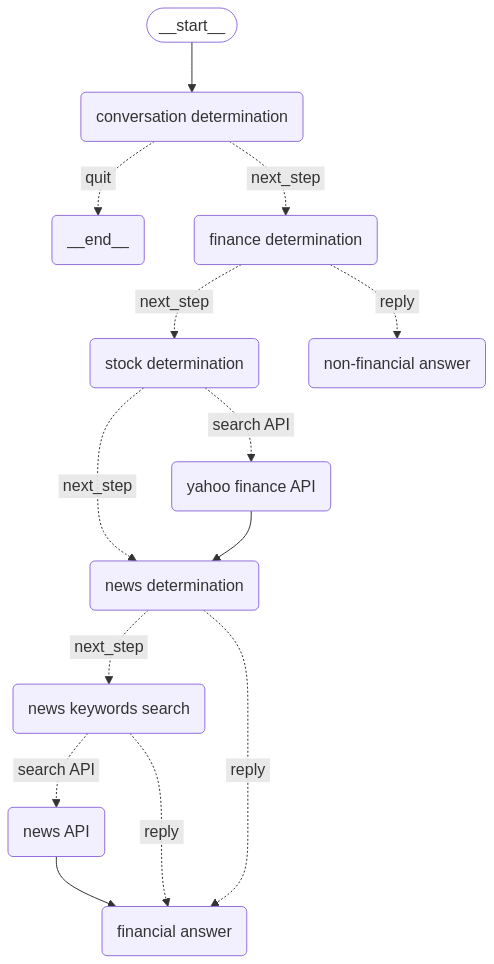

In [5]:
graph = StateGraph(InvestmentState)
### 節點
graph.add_node('conversation determination', conversation_determination)
graph.add_node('finance determination', finance_question_determination)
graph.add_node('non-financial answer' ,answer_non_financial_question)
graph.add_node('stock determination', get_stock_code)
graph.add_node('yahoo finance API' ,get_stock_info)
graph.add_node('news determination' ,need_news_search)
graph.add_node('news keywords search' ,get_news_keywords)
graph.add_node('news API', get_latest_news)
graph.add_node('financial answer', investment_llm)

### 連接
graph.set_entry_point('conversation determination')
graph.add_edge('yahoo finance API', 'news determination')
graph.add_edge('news API', 'financial answer')

### 條件
# 對話判定
graph.add_conditional_edges(
    'conversation determination',
    continuing_conversation_condition,
    {
        'quit': END,
        'next_step': 'finance determination'
    } 
)
# 財經判定
graph.add_conditional_edges(
    'finance determination',
    finance_question_determination_condition,
    {
        'next_step': 'stock determination',
        'reply': 'non-financial answer'
    } 
)
# 股票判定
graph.add_conditional_edges(
    'stock determination',
    stock_need_determination_condition,
    {
        'next_step': 'news determination',
        'search API': 'yahoo finance API'
    }   
)
# 新聞判定
graph.add_conditional_edges(
    'news determination',
    news_need_determination_condition,
    {
        'next_step': 'news keywords search',
        'reply': 'financial answer'
    }   
)
# 關鍵字判定
graph.add_conditional_edges(
    'news keywords search',
    news_keywords_determination_condition,
    {
        'search API': 'news API',
        'reply': 'financial answer'
    }   
)

### 流程圖
investment_pipeline = graph.compile()
display(Image(investment_pipeline.get_graph().draw_mermaid_png()))

In [6]:
response = investment_pipeline.invoke({
    'query': query3,
})

搜索回答中...
  -> 對話為財經問題，進行股票查詢
查詢股票代碼中...
搜尋 Yahoo Finance API 中...
📈 獲取股票資料: 0050.TW 中...
  -> 從 API 獲取股票資料: 0050.TW
查詢新聞關鍵詞中...
🧩 查詢新聞關鍵詞: 「元大50, 調整, 股價」 中...
查詢 News API 中...
  ->從 API 獲取新聞資料: 元大50, 調整, 股價
  ->從 API 獲取新聞資料: 元大50
  ->從 API 獲取新聞資料: 調整
  ->從 API 獲取新聞資料: 股價
📣 查詢相關新聞:
  1. 0050啟動分割4/21投票截止，「1張變5張」大幅降低投資人入手門檻
  2. 北捷常客優惠 3 月起縮水，最高 30% 回饋金剩 15%
  3. PyTorch 灵魂人物 Horace He 从 Meta 出走，选择 OpenAI 前 CTO 初创公司
  4. 婦聯調查：逾七成港人不願生育 倡生育獎金加碼
  5. 佳世達擬現金減資每股1.8元 (圖)
  6. 【MWC 2025】德國電信攜手 Perplexity 打造 AI 手機，售價不到 1000 美元，挑戰蘋果與 Google 壟斷
  7. 營收速報 - 華新(1605)2月營收154.31億元年增率高達30.88％
  8. 台積電豪賭3.3兆丟美國！分析師曝「2好3壞」：股東短痛長笑...股價到「這裡」就可彎腰撿
📑檢索最相關文件:
相似度分數: 0.2954988479614258
新聞內容: 0050啟動分割4/21投票截止，「1張變5張」大幅降低投資人入手門檻 
 為降低投資人入手門檻，元大台灣50（0050）ETF將分割，預計以發行價36.98元整數倍為基準調整淨值及股數，分割後總資產價值不變，藉此降低投資門檻。受益人會議將於4月24日召開，電子投票至4月21日截止。
相似度分數: 0.32556432485580444
新聞內容: 佳世達擬現金減資每股1.8元 (圖) 
 佳世達財務長洪秋金（圖）5日在台灣證券交易所重大訊息記者會表示，為調整資本結構及提升股東權益報酬率，擬辦理現金減資，減資比率為18%，每股退還現金約1.8元。
相似度分數: 0.3414081335067749
新聞內容: 台積電豪賭3.3兆丟美國！分

In [7]:

for i in range(1,9):
    response = investment_pipeline.invoke({
        'query': globals().get(f"query{i}"),
    })


搜索回答中...
  -> 對話為財經問題，進行股票查詢
查詢股票代碼中...
搜尋 Yahoo Finance API 中...
📈 獲取股票資料: 3231.TW 中...
  -> 從 API 獲取股票資料: 3231.TW
查詢新聞關鍵詞中...
🧩 查詢新聞關鍵詞: 「緯創, 投資價值」 中...
查詢 News API 中...
  ->從 API 獲取新聞資料: 緯創, 投資價值
  ->從 API 獲取新聞資料: 緯創
  ->從 API 獲取新聞資料: 投資價值
📣 查詢相關新聞:
  1. 台股開盤》短線漲多陷觀望 市場靜待美國CPI 大盤漲逾136點
  2. 汎瑋材料1月營收雙減，看好AI伺服器需求爆發帶來成長性
  3. 小七「賣貨便」迎6週年慶　加碼優惠抽黃金與咖啡免費喝
  4. 台股補跌，各類股全面下跌
  5. 台積電擴大美投資! 南科管理局:嘉義擴廠計畫不受影響
  6. 趨勢科技推出首款資安大型語言模型，主動式資安 AI 助企業預測及防範網路攻擊
📑檢索最相關文件:
相似度分數: 0.38435906171798706
新聞內容: 台積電擴大美投資! 南科管理局:嘉義擴廠計畫不受影響 
 財經中心／葉為襄、嚴凱 台北報導台積電宣布在美國擴大投資設廠，比原先投資多加碼3.3兆新台幣，如此一來日本德國和台灣的投資是否受到影響？不過，南科管理局說，嘉義擴廠計畫不受影響，至於美國投資人倒視為是一大利多，台積電ADR收漲4.06%，激勵台北股市、台積電股價開盤大漲30元，市值來到26.7兆。
相似度分數: 0.40605729818344116
新聞內容: 台股開盤》短線漲多陷觀望 市場靜待美國CPI 大盤漲逾136點 
 [Newtalk新聞] 台股今天(12日)開紅，漲逾136點，最高來到23,528.61點，上櫃、電子與金融類股全開紅、走漲！四大電子權值股F4，約9點10分前，台積電平盤、維持1110元。鴻海漲1.5元、來到180.5元。廣達漲1元、來到259元。聯發科漲30元、來到1540元。 川普2.0關稅 鮑爾談話 美股漲跌互見 快速掃描美股昨天(11日)週二表現，四大指數漲跌互見，美國聯準會(Fed)主席鮑爾聽證會重申不急於降息。鮑爾表示不急於放鬆貨幣政策，投資人消化政策方向導致美股陷入觀望，近期強勢的AI軟硬體股，多…
相